In [1]:
import pandas as pd 
import yfinance as yf
import numpy as np
import datetime as dt

Workflow

- List of stock tickers
- Check each ticker date-back data earilest
- Use earliest data of available data as date-start
- calculate CAPM of each stock regarding their date-start and date-end

In [2]:
### List of stock tickers

def get_tickers(file_path):
    tickers = pd.read_excel(file_path,sheet_name='listedCompanies_th_TH',skiprows = 1)
    tickers = tickers.rename(columns={'หลักทรัพย์' : 'ticker'})
    tickers = tickers.rename(columns={'ตลาด' : 'market'})
    col_list = tickers.columns
    for i in col_list:
        if i not in ['ticker','market']:
            tickers = tickers.drop(columns=i)
    tickers['ticker'] = tickers['ticker'].astype('str') + '.bk'
    return tickers
     

tickers = get_tickers('stock_info_th.xlsx')
tickers

,ticker,market
0,24CS.bk,mai
1,2S.bk,SET
2,3BBIF.bk,SET
3,3K-BAT.bk,SET
4,A.bk,SET
...,...,...
916,YONG.bk,mai
917,YUASA.bk,mai
918,ZAA.bk,SET
919,ZEN.bk,SET


In [3]:
## Check each ticker date-back data earilest and set date-start

def find_date_start(ticker):
    try:
        date_list = yf.Ticker(ticker).financials.loc['Operating Income'].dropna().index
        date_earliest = date_list[len(date_list)-1].year
        date_start = str(date_earliest) + '-01-01'
    except:
        date_start = None
    return date_start

tickers['date_start'] = ''
for i in range(len(tickers)):
    tickers['date_start'][i] = find_date_start(tickers['ticker'][i])
tickers = tickers.loc[~(tickers['date_start'].isnull())]
tickers.reset_index(inplace=True,drop=True)
tickers


/var/folders/rx/tstwq_0j2fs2k5dh4m8xnhdc0000gn/T/ipykernel_3614/2805548614.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tickers['date_start'][i] = find_date_start(tickers['ticker'][i])
/var/folders/rx/tstwq_0j2fs2k5dh4m8xnhdc0000gn/T

,ticker,market,date_start
0,24CS.bk,mai,2020-01-01
1,2S.bk,SET,2020-01-01
2,3K-BAT.bk,SET,2020-01-01
3,A.bk,SET,2020-01-01
4,A5.bk,mai,2020-01-01
...,...,...,...
856,YONG.bk,mai,2020-01-01
857,YUASA.bk,mai,2020-01-01
858,ZAA.bk,SET,2020-01-01
859,ZEN.bk,SET,2020-01-01


beta =  -0.081114079498676
daily avg r =  -0.05357071602448521
rm = -4.1785158499098465
ER =  0.44704787478593255


/var/folders/rx/tstwq_0j2fs2k5dh4m8xnhdc0000gn/T/ipykernel_3614/3223477668.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
/var/folders/rx/tstwq_0j2fs2k5dh4m8xnhdc0000gn/

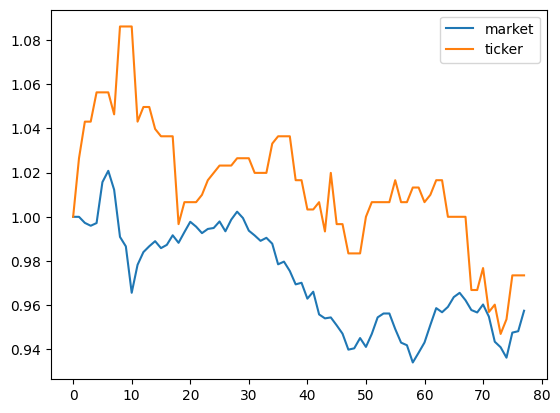

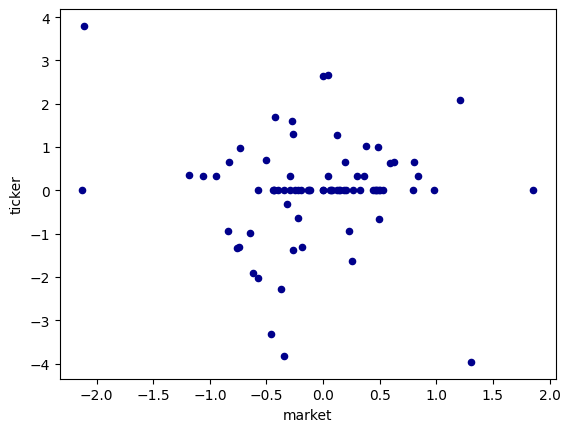

In [4]:
## calculate CAPM of each stock regarding their date-start and date-end

def normalize(df):
  x = df.copy()
  for i in x.columns[0:]:
    x[i] = x[i]/x[i][0]
  return x

def daily_return(df):
    df_daily_return = df.copy()
    for i in df.columns[0:]:
        for j in range(1, len(df)):
            df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
        df_daily_return[i][0] = 0
    return df_daily_return

def cal_CAPM(market,ticker,riskfreerate,date_start,date_end):
    try:
        m = yf.Ticker(market).history(start=date_start, end=date_end, interval="1d")
        s = yf.Ticker(ticker).history(start=date_start, end=date_end, interval="1d")
        m.reset_index(inplace=True)
        s.reset_index(inplace=True)
        m['1d'] = m['Date'].dt.date
        s['1d'] = s['Date'].dt.date
        m = m.drop(columns=['Date'])
        s = s.drop(columns=['Date'])
        m = m.set_index('1d')
        s = s.set_index('1d')

        data = pd.DataFrame()
        data['market'] = m['Close']
        data['ticker'] = s['Close']
        
        data = data.loc[~(data['market'].isna() | data['ticker'].isna())]
        data.reset_index(inplace=True,drop=True)

        data = normalize(data)
        data.plot()
        data_daily_return = daily_return(data)
        data_daily_return.plot.scatter(x='market',
                      y='ticker',
                      c='DarkBlue',)
        beta, alpha = np.polyfit(data_daily_return['market'], data_daily_return['ticker'], 1)
        data_daily_return['market'].mean()
        rm = data_daily_return['market'].mean() * len(data_daily_return)
        ER = riskfreerate + (beta * (rm-riskfreerate)) 
        print('beta = ',beta)
        print('daily avg r = ',data_daily_return['market'].mean())
        print('rm =',rm)
    except:
        print('ticker not found')
        ER = None

    return ER


market = "^SET.bk"
stock = 'pttep.bk'
date_start =  "2024-04-01" #tickers['date_start'].loc[tickers['ticker'] == stock].values[0]
date_end = "2024-08-01"
test = cal_CAPM(market,stock,0.1,date_start,date_end)
print('ER = ',test)